In [2]:
import sys
sys.path.append('/Users/jinchen/Desktop/DSE/IntroML/Project/project-product-price-prediction')

In [132]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
matplotlib.rcParams['figure.figsize'] = (15, 8)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from final.feature_extraction.clean_text import *
from final.feature_encoding.one_hot_encoding import one_hot_encode_feature
from final.feature_extraction.extract_text_info import extract_general_row_info, extract_row_word_counts

In [153]:
df = pd.read_csv("../../data/random_samples/stratified_sampling_data_by_c1_sz50000_1619216598.csv")
df.shape

(50000, 10)

In [154]:
df.head(4)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,c1,c2,c3
0,1341364,Toddler Jordans size 11c,2,Nike,35.0,1,Boy's Jordan's size 11c. Like new condition. U...,kids,boys 2t-5t,shoes
1,1311357,Urban Decay Naked 2 Eyeshadow Palette,2,Urban Decay,29.0,0,"swatched, authentic, and in good condition. Ma...",beauty,makeup,makeup palettes
2,28470,Bath & Body Works Scentportable,3,Bath & Body Works,5.0,1,Skull with Bow,home,home décor,home fragrance
3,208231,Pokémon Snap N64,4,Nintendo,12.0,0,Tested and cleaned. Guaranteed to work like ne...,electronics,video games & consoles,games


# Encode C1

In [155]:
encode_df, encode_col = one_hot_encode_feature(df, encode_column='c1',drop_first=False)
encode_df.shape

(50000, 18)

In [156]:
encode_df.head(5)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,c2,c3,c1_beauty,c1_electronics,c1_home,c1_kids,c1_men,c1_other,c1_sports & outdoors,c1_vintage & collectibles,c1_women
0,1341364,Toddler Jordans size 11c,2,Nike,35.0,1,Boy's Jordan's size 11c. Like new condition. U...,boys 2t-5t,shoes,0,0,0,1,0,0,0,0,0
1,1311357,Urban Decay Naked 2 Eyeshadow Palette,2,Urban Decay,29.0,0,"swatched, authentic, and in good condition. Ma...",makeup,makeup palettes,1,0,0,0,0,0,0,0,0
2,28470,Bath & Body Works Scentportable,3,Bath & Body Works,5.0,1,Skull with Bow,home décor,home fragrance,0,0,1,0,0,0,0,0,0
3,208231,Pokémon Snap N64,4,Nintendo,12.0,0,Tested and cleaned. Guaranteed to work like ne...,video games & consoles,games,0,1,0,0,0,0,0,0,0
4,81684,NWT Sexy Valentine's Day Dress Rue21 XL,1,rue,8.0,1,New ladies Rue21 Cocktail/Party dress. Size XL...,dresses,"above knee, mini",0,0,0,0,0,0,0,0,1


In [157]:
encode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   train_id                   50000 non-null  int64  
 1   name                       50000 non-null  object 
 2   item_condition_id          50000 non-null  int64  
 3   brand_name                 50000 non-null  object 
 4   price                      50000 non-null  float64
 5   shipping                   50000 non-null  int64  
 6   item_description           50000 non-null  object 
 7   c2                         50000 non-null  object 
 8   c3                         50000 non-null  object 
 9   c1_beauty                  50000 non-null  uint8  
 10  c1_electronics             50000 non-null  uint8  
 11  c1_home                    50000 non-null  uint8  
 12  c1_kids                    50000 non-null  uint8  
 13  c1_men                     50000 non-null  uin

# Extract Item Name Features

In [158]:
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
num_of_processes  = 8
col_name = 'name'
clean_col_name = "clean_%s" % col_name

df = parallelize(encode_df, partial(extract_counts, col_name=col_name, prefix="bef"), num_of_processes)
df = parallelize(encode_df, partial(extract_info, col_name=col_name, stop_words=stop_words), num_of_processes)

[nltk_data] Downloading package wordnet to /Users/jinchen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
progress-bar: 100%|██████████| 6250/6250 [01:09<00:00, 89.73it/s] 

progress-bar: 100%|██████████| 6250/6250 [01:09<00:00, 89.32it/s]


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   train_id                   50000 non-null  int64  
 1   name                       50000 non-null  object 
 2   item_condition_id          50000 non-null  int64  
 3   brand_name                 50000 non-null  object 
 4   price                      50000 non-null  float64
 5   shipping                   50000 non-null  int64  
 6   item_description           50000 non-null  object 
 7   c2                         50000 non-null  object 
 8   c3                         50000 non-null  object 
 9   c1_beauty                  50000 non-null  int64  
 10  c1_electronics             50000 non-null  int64  
 11  c1_home                    50000 non-null  int64  
 12  c1_kids                    50000 non-null  int64  
 13  c1_men                     50000 non-null  int

#  Split Train Test

In [160]:
X = df.select_dtypes(include=['int64']).drop(columns=list(encode_col)+['train_id'])
x_col = X.columns
X['name'] = df['name']
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   item_condition_id  50000 non-null  int64 
 1   shipping           50000 non-null  int64 
 2   upper_word_count   50000 non-null  int64 
 3   upper_char_count   50000 non-null  int64 
 4   stopword_count     50000 non-null  int64 
 5   punctuation_count  50000 non-null  int64 
 6   number_count       50000 non-null  int64 
 7   name               50000 non-null  object
dtypes: int64(7), object(1)
memory usage: 3.1+ MB


In [161]:
y = encode_df[encode_col]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   c1_beauty                  50000 non-null  uint8
 1   c1_electronics             50000 non-null  uint8
 2   c1_home                    50000 non-null  uint8
 3   c1_kids                    50000 non-null  uint8
 4   c1_men                     50000 non-null  uint8
 5   c1_other                   50000 non-null  uint8
 6   c1_sports & outdoors       50000 non-null  uint8
 7   c1_vintage & collectibles  50000 non-null  uint8
 8   c1_women                   50000 non-null  uint8
dtypes: uint8(9)
memory usage: 439.6 KB


In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.30, random_state=42, stratify = y)

In [163]:
X_train.shape

(35000, 8)

# Vectorization of Item Name

In [164]:
num_features = 20
tv = TfidfVectorizer(max_features=num_features)
train_name_feature = tv.fit_transform(X_train.name.to_list())

train_name_feature.toarray().shape

(35000, 20)

In [165]:
X_train = np.concatenate((train_name_feature.toarray(), X_train[x_col].values),axis=1)
X_train.shape

(35000, 27)

In [166]:
X_test = np.concatenate((hv.transform(X_test.name.to_list()).toarray(), X_test[x_col].values),axis=1)
X_test.shape

(15000, 27)

In [167]:
names = tv.get_feature_names()
names


['and',
 'black',
 'bundle',
 'dunn',
 'fitbit',
 'for',
 'free',
 'funko',
 'iphone',
 'men',
 'new',
 'nike',
 'of',
 'pink',
 'pop',
 'rae',
 'set',
 'shirt',
 'size',
 'under']

In [168]:
x_tf_names = ['tf%02d_%s'%(i,names[i-1]) for i in range(1, num_features+1)]
x_tf_names += list(x_col)
x_tf_names

['tf01_and',
 'tf02_black',
 'tf03_bundle',
 'tf04_dunn',
 'tf05_fitbit',
 'tf06_for',
 'tf07_free',
 'tf08_funko',
 'tf09_iphone',
 'tf10_men',
 'tf11_new',
 'tf12_nike',
 'tf13_of',
 'tf14_pink',
 'tf15_pop',
 'tf16_rae',
 'tf17_set',
 'tf18_shirt',
 'tf19_size',
 'tf20_under',
 'item_condition_id',
 'shipping',
 'upper_word_count',
 'upper_char_count',
 'stopword_count',
 'punctuation_count',
 'number_count']

# Classification - Random Forest

In [169]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [170]:
importances = model.feature_importances_
indices = np.argsort(importances, )

for i in indices[::-1]:
    print('%-20s --> Score: %.5f' % (x_tf_names[i],importances[i]))

upper_char_count     --> Score: 0.22956
punctuation_count    --> Score: 0.08708
item_condition_id    --> Score: 0.08480
upper_word_count     --> Score: 0.06074
tf16_rae             --> Score: 0.05451
tf05_fitbit          --> Score: 0.04785
tf09_iphone          --> Score: 0.04384
tf10_men             --> Score: 0.03974
tf04_dunn            --> Score: 0.03817
stopword_count       --> Score: 0.03557
number_count         --> Score: 0.02910
tf12_nike            --> Score: 0.02797
shipping             --> Score: 0.02415
tf20_under           --> Score: 0.02185
tf03_bundle          --> Score: 0.01822
tf14_pink            --> Score: 0.01759
tf19_size            --> Score: 0.01699
tf08_funko           --> Score: 0.01634
tf11_new             --> Score: 0.01631
tf18_shirt           --> Score: 0.01581
tf15_pop             --> Score: 0.01245
tf06_for             --> Score: 0.01140
tf02_black           --> Score: 0.01122
tf17_set             --> Score: 0.01055
tf01_and             --> Score: 0.00980


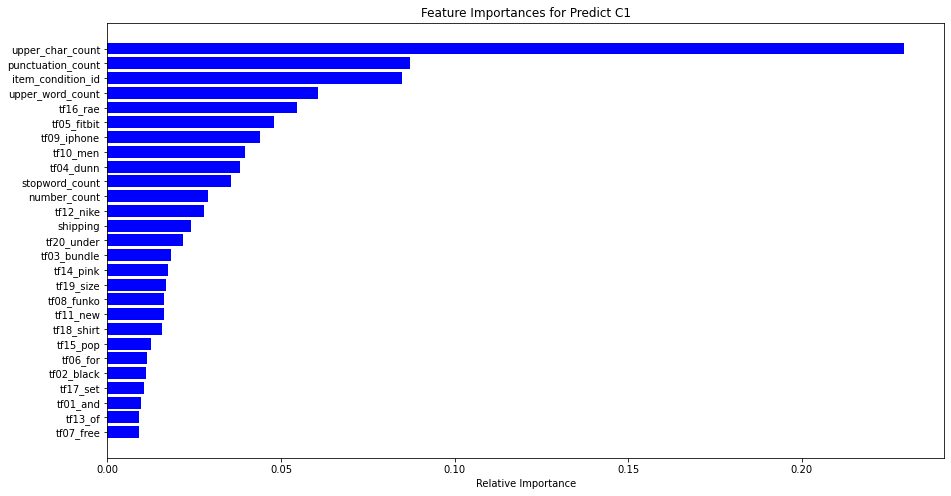

In [171]:
# plot feature importance
plt.title('Feature Importances for Predict C1')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [x_tf_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Evaluate Accuracy

In [172]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [173]:
y_train = np.argmax(y_train, axis = 1)
y_train_pred = np.argmax(y_train_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
y_test_pred = np.argmax(y_test_pred, axis = 1)

In [174]:
print("Train Acc:", accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

Train Acc: 0.46334285714285717
[[3716   10   13   12    4  103    4   18    9]
 [2109 1688    9    5    4   23    1   41    9]
 [1724    8 2068    6    3   56    3    9   12]
 [2492   22   13 1175   20   35   18   92   22]
 [1935   15    3   24 1766   18   85   13   30]
 [2477   11   32    7   10 1335    1    7    9]
 [1811   15    7   17   52   14 1945   10   17]
 [2439   29   14   28    7   31    1 1321   19]
 [2513   21   10   25   31   22   44   20 1203]]


In [175]:
print("Test Acc:", accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

Test Acc: 0.29893333333333333
[[1427   31   35   23   11   72    9   25   34]
 [1063  459   18   16   14   28    8   45   15]
 [ 857   10  708   16    2   48    2   10   14]
 [1270   37   17   83   47   37   39   95   42]
 [ 953   16    5   43  463   28  100   12   47]
 [1235   18   19   21   32  303    6   19   14]
 [ 886   18   17   29   90   15  562   18   31]
 [1154   47   25   67   10   26    9  288   41]
 [1248   33   14   36   55   21   39   29  191]]


#  Visualization 

In [176]:
model_train_df = pd.DataFrame(X_train, columns = x_tf_names)

In [177]:
model_train_df['c1_true'] = list(map(lambda x: encode_col[x], y_train))
model_train_df['c1_pred'] = list(map(lambda x: encode_col[x], y_train_pred))

<AxesSubplot:xlabel='upper_char_count', ylabel='punctuation_count'>

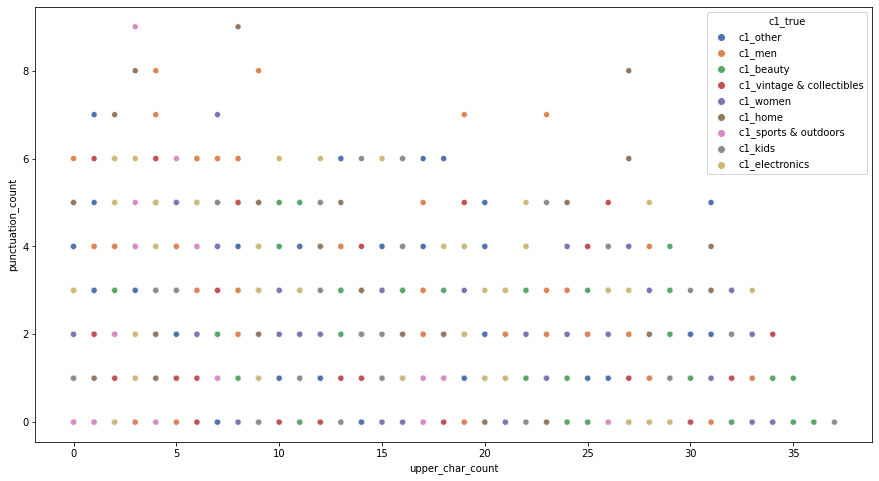

In [178]:
sns.scatterplot(data=model_train_df, x="upper_char_count", y="punctuation_count", hue="c1_true", palette="deep")

<AxesSubplot:xlabel='upper_char_count', ylabel='punctuation_count'>

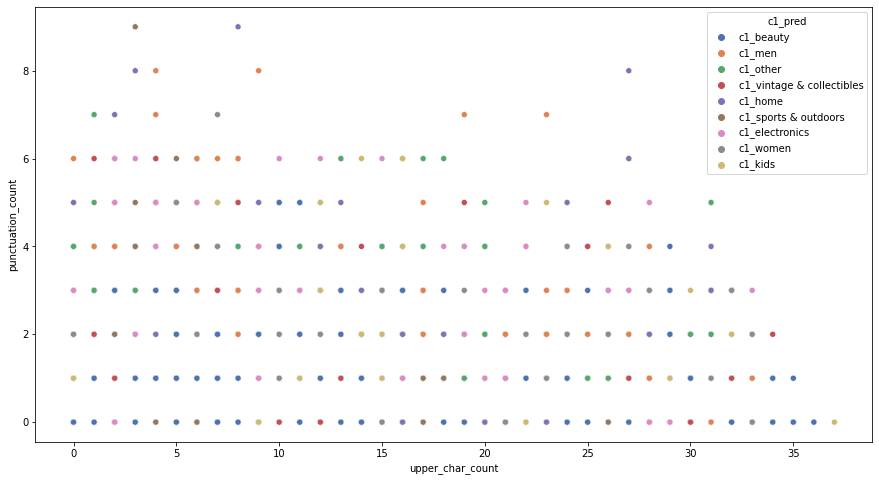

In [179]:
sns.scatterplot(data=model_train_df, x="upper_char_count", y="punctuation_count", hue="c1_pred", palette="deep")

In [180]:
model_test_df = pd.DataFrame(X_test, columns = x_tf_names)
model_test_df['c1_true'] = list(map(lambda x: encode_col[x], y_test))
model_test_df['c1_pred'] = list(map(lambda x: encode_col[x], y_test_pred))

<AxesSubplot:xlabel='upper_char_count', ylabel='punctuation_count'>

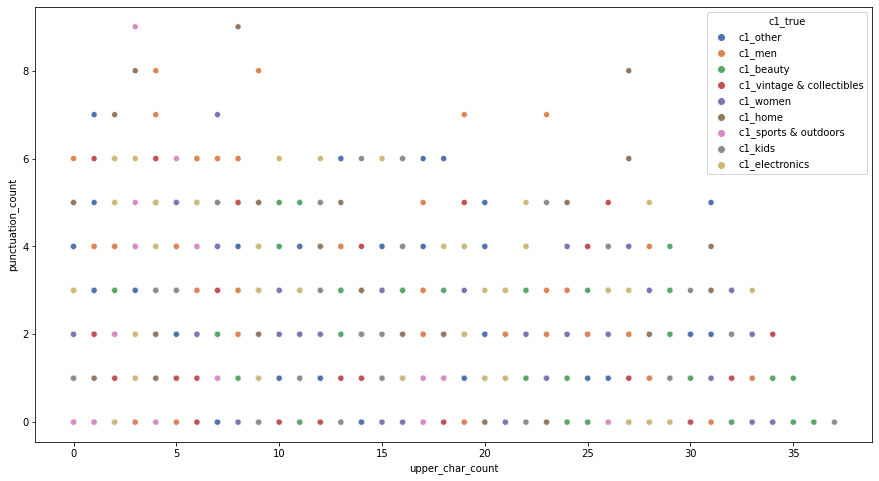

In [181]:
sns.scatterplot(data=model_train_df, x="upper_char_count", y="punctuation_count", hue="c1_true", palette="deep")

# PCA

In [182]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pca.explained_variance_ratio_

array([8.95551882e-01, 3.18532452e-02, 2.35520324e-02, 9.37096175e-03,
       9.01520620e-03, 8.73327512e-03, 6.71115377e-03, 1.45912923e-03,
       1.42114947e-03, 1.36673613e-03, 1.19380615e-03, 9.92846899e-04,
       9.34939104e-04, 8.49838679e-04, 7.62062255e-04, 7.38136933e-04,
       7.08898269e-04, 6.83420104e-04, 6.56416652e-04, 6.54251627e-04,
       6.33296241e-04, 5.98494007e-04, 5.47668742e-04, 5.30799367e-04,
       3.52299789e-04, 1.20142578e-04, 7.91164896e-06])

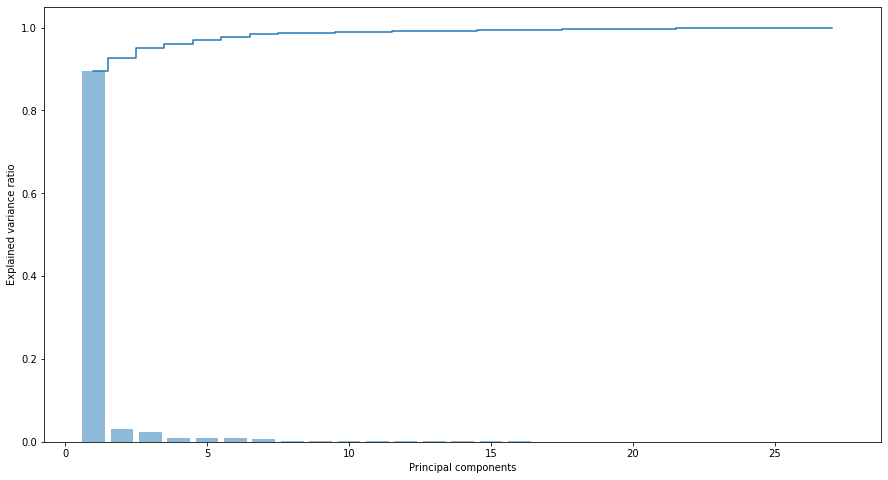

In [183]:
num_components = len(pca.explained_variance_ratio_)
x_label = range(1, 1 + num_components)
plt.bar(x_label, pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(x_label, np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [184]:
X_train_pca.shape

(35000, 27)

In [185]:
# use df with sns to plot
pca_df = pd.DataFrame({"PC 1": X_train_pca[:, 0], "PC 2": X_train_pca[:, 1]})
pca_df['c1_true'] = list(map(lambda x: encode_col[x], y_train))

<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

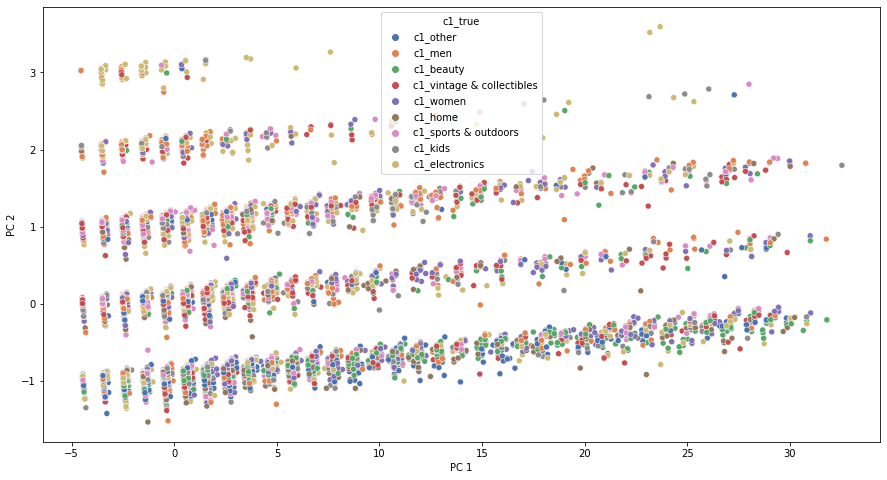

In [186]:
sns.scatterplot(data=pca_df, x="PC 1", y="PC 2", hue="c1_true",palette="deep")


# Model for PCA

In [196]:
pca_model = RandomForestClassifier(n_estimators=50)
pca_model.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [197]:
y_train_pred_pca = model.predict(X_train_pca)
y_test_pred_pca = model.predict(X_test_pca)

In [198]:
y_train_pred_pca = np.argmax(y_train_pred_pca, axis = 1)
y_test_pred_pca = np.argmax(y_test_pred_pca, axis = 1)

In [199]:
print("Train Acc:", accuracy_score(y_train, y_train_pred_pca))
print(confusion_matrix(y_train, y_train_pred_pca))

Train Acc: 0.09362857142857142
[[2503  208  346    0    2   16  814    0    0]
 [3016   60  298    0    6    3  446    0   60]
 [1565   53  159    0    2   10 2100    0    0]
 [2704  151  207    0    1    6  685  135    0]
 [2820   49  137    0    1    2  650  230    0]
 [2638  244  260    0    1    9  737    0    0]
 [1990   33 1019    0    0   12  540  294    0]
 [2887   57  341    0    0    8  591    5    0]
 [2832   95  187    0    0   18  676   81    0]]


In [200]:
print("Test Acc:", accuracy_score(y_test, y_test_pred_pca))
print(confusion_matrix(y_test, y_test_pred_pca))

Test Acc: 0.09386666666666667
[[1074   94  154    0    1    5  339    0    0]
 [1306   38  102    0    1    2  197    0   20]
 [ 683   24   68    0    0    3  889    0    0]
 [1145   67  102    0    0    4  280   69    0]
 [1194   22   56    0    0    0  280  115    0]
 [1154   93   86    0    1    1  330    2    0]
 [ 894   18  413    2    0    4  222  113    0]
 [1274   25  130    0    0    3  230    5    0]
 [1203   32   82    0    0    5  300   44    0]]


In [ ]:
# feature_df = clean_text_with_extract_info(encode_df, col_name="name")
# feature_df.to_csv("../../data/random_samples/stratified_sampling_data_by_c1_sz50000_1619216598_wNameFeature.csv", index=False)